In [1]:
import numpy as np
import math as m
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy
import matplotlib.pyplot as plt

In [2]:
# Systematic Covariance Matrix
sysmtx = np.genfromtxt("sys_full_long.txt");
Csys = sysmtx.reshape([1048,1048],order='F')

# Statistical matrix
data2 = open("lcparamfull_full_long.txt",'r').readlines()
rawstat=[]
for x in data2:
    rawstat.append(x.split(' ')[5])
#ss = np.diag(rawstat)

ss = []
for i in rawstat: 
    unstrung = eval(i)
    ss.append(unstrung)
Dstat = np.diag(ss)
D = np.multiply(Dstat,Dstat)

# Full covariance matrix
C = np.zeros(shape=(1048,1048)) # Creating zero matrix

# Iterate through rows
for i in range(len(Csys)):
   # Iterate through columns
   for j in range(len(Csys[0])):
       C[i][j] = Csys[i][j] + D[i][j] 
    
# Inverse covariance matrix
invC = np.linalg.inv(C)

In [3]:
# Redshift data
rawz=[]
for x in data2:
    rawz.append(x.split(' ')[2])
sz = np.array(rawz)
#unstring redshift array values
rs = []
for i in sz: 
    unstrung = eval(i)
    rs.append(unstrung)
    
# B-band apparent magnitude data 
rawmb = []
for x in data2:
    rawmb.append(x.split(' ')[4])
smb = np.array(rawmb)
#unstring mb array values
mb = []
for i in smb: 
    unstrung = eval(i)
    mb.append(unstrung)

In [7]:
# Pantheon Data 

# Defining constants
K = int(input('Number of w data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)
w = np.linspace(-2,-0.1,K)
om = 0.298


crs = []
for i in H0:
    for j in rs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([1048,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value


colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in w:
    for j in rs:
        def F(x):
            return 1/m.sqrt(om*(1+x)**3+(1-om)*((1+x)**(3*(1-i/(1+x))))*m.exp(6*i*(1-1/(1+x))))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([1048,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in mb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
chidict = {}
# Obtaining chi2 value at each omg_m
chi2 = []
for i in range(K*H):
    cdrv = np.dot(invC,drv[i])
    chi2i = np.dot(drv[i].T,cdrv)
    chi2.append(chi2i)
    chidict[chi2[i]] = i

print('The minimum chi2 value is ',min(chidict.keys()))
print('The ith value for minimum chi2 is ',chidict[min(chidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(chidict[min(chidict.keys())]/K)])
print('The w value for minimum chi2 is ',w[chidict[min(chidict.keys())]-int(chidict[min(chidict.keys())]/K)*K])

Number of w data points:100
Number of H_0 data points:100
The minimum chi2 value is  1026.93809444613
The ith value for minimum chi2 is  6751
The H0 value for minimum chi2 is  73535.35353535354
The w value for minimum chi2 is  -1.0212121212121212


In [8]:
# Find lowest and highest H0 and Om values 

def condition(x): return (x <= min(chidict.keys())+6.4)
output = [idx for idx, element in enumerate(chi2) if condition(element)]
#print(output)

print('The upper end H0 value is ',H0[int(max(output)/K)])
print('The lower end H0 value is ',H0[int(min(output)/K)])
print('H0 +',H0[int(max(output)/K)] - H0[int(chidict[min(chidict.keys())]/K)])
print('H0 -',H0[int(chidict[min(chidict.keys())]/K)] - H0[int(min(output)/K)])
print('The upper end Wa value is ',w[min(output)-int(min(output)/K)*K])
print('The lower end Wa value is ',w[max(output)-int(max(output)/K)*K])
print('Wa +',w[min(output)-int(min(output)/K)*K] - w[chidict[min(chidict.keys())]-int(chidict[min(chidict.keys())]/K)*K])
print('Wa -',w[chidict[min(chidict.keys())]-int(chidict[min(chidict.keys())]/K)*K] - w[max(output)-int(max(output)/K)*K])

The upper end H0 value is  74545.45454545454
The lower end H0 value is  72525.25252525252
H0 + 1010.1010101010033
H0 - 1010.1010101010179
The upper end Wa value is  -0.9060606060606062
The lower end Wa value is  -1.1363636363636365
Wa + 0.115151515151515
Wa - 0.11515151515151523


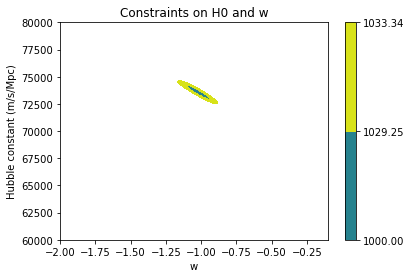

In [9]:
# Creating chi2 contours

chi = np.array(chi2).reshape(100,100)
W, h0 = np.meshgrid(w, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(W, h0, chi, levels=[1000,1029.25,1033.34]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and w')
ax.set_xlabel('w')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

## Redshift Binning (3 Bins)

In [10]:
Ars = []
Amb = []
Ai = []
Brs = []
Bmb = []
Bi = []
Crs = []
Cmb = []
Ci = []


for i in range(len(rs)):
    if (rs[i] <= 0.177):
        Ars.append(rs[i])
        Amb.append(mb[i])
        Ai.append(i)
    elif (rs[i] > 0.177 and rs[i] <= 0.33745):
        Brs.append(rs[i])
        Bmb.append(mb[i])
        Bi.append(i)
    else:
        Crs.append(rs[i])
        Cmb.append(mb[i])
        Ci.append(i)
        
np.array(Ci).size

350

In [11]:
# Covariance for A-Bin
Acov = []
for i in range(len(Ai)):
    for j in range(len(Ai)):
        Acov.append(C[Ai[i]][Ai[j]])
AC = np.array(Acov).reshape([349,349],order='F')
invA = np.linalg.inv(AC)

# Covariance for B-Bin
Bcov = []
for i in range(len(Bi)):
    for j in range(len(Bi)):
        Bcov.append(C[Bi[i]][Bi[j]])
BC = np.array(Bcov).reshape([349,349],order='F')
invB = np.linalg.inv(BC)

# Covariance for C-Bin
Ccov = []
for i in range(len(Ci)):
    for j in range(len(Ci)):
        Ccov.append(C[Ci[i]][Ci[j]])
CC = np.array(Ccov).reshape([350,350],order='F')
invCC = np.linalg.inv(CC)

## A Bin

In [12]:
# Pantheon Data 

# Defining constants
K = int(input('Number of w data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)
w = np.linspace(-2,-0.1,K)
om = 0.298


crs = []
for i in H0:
    for j in Ars:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([349,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value


colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in w:
    for j in Ars:
        def F(x):
            return 1/m.sqrt(om*(1+x)**3+(1-om)*((1+x)**(3*(1-i/(1+x))))*m.exp(6*i*(1-1/(1+x))))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([349,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in Amb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Achidict = {}
# Obtaining chi2 value at each omg_m
Achi2 = []
for i in range(K*H):
    cdrv = np.dot(invA,drv[i])
    Achi2i = np.dot(drv[i].T,cdrv)
    Achi2.append(Achi2i)
    Achidict[Achi2[i]] = i

print('The minimum chi2 value is ',min(Achidict.keys()))
print('The ith value for minimum chi2 is ',Achidict[min(Achidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Achidict[min(Achidict.keys())]/K)])
print('The w value for minimum chi2 is ',w[Achidict[min(Achidict.keys())]-int(Achidict[min(Achidict.keys())]/K)*K])

Number of w data points:100
Number of H_0 data points:100
The minimum chi2 value is  351.83945605065065
The ith value for minimum chi2 is  6945
The H0 value for minimum chi2 is  73939.39393939394
The w value for minimum chi2 is  -1.1363636363636365


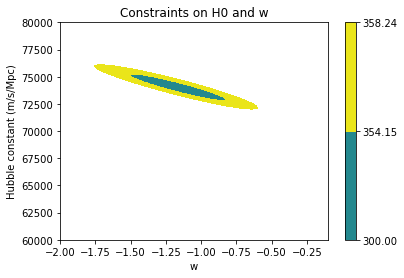

In [14]:
# Creating chi2 contours

Achi = np.array(Achi2).reshape(100,100)
W, h0 = np.meshgrid(w, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(W, h0, Achi, levels=[300,354.15,358.24]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and w')
ax.set_xlabel('w')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

## B Bin

In [15]:
# Pantheon Data 

# Defining constants
K = int(input('Number of w data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)
w = np.linspace(-2,-0.1,K)
om = 0.298


crs = []
for i in H0:
    for j in Brs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([349,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value


colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in w:
    for j in Brs:
        def F(x):
            return 1/m.sqrt(om*(1+x)**3+(1-om)*((1+x)**(3*(1-i/(1+x))))*m.exp(6*i*(1-1/(1+x))))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([349,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in Bmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Bchidict = {}
# Obtaining chi2 value at each omg_m
Bchi2 = []
for i in range(K*H):
    cdrv = np.dot(invB,drv[i])
    Bchi2i = np.dot(drv[i].T,cdrv)
    Bchi2.append(Bchi2i)
    Bchidict[Bchi2[i]] = i

print('The minimum chi2 value is ',min(Bchidict.keys()))
print('The ith value for minimum chi2 is ',Bchidict[min(Bchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Bchidict[min(Bchidict.keys())]/K)])
print('The w value for minimum chi2 is ',w[Bchidict[min(Bchidict.keys())]-int(Bchidict[min(Bchidict.keys())]/K)*K])

Number of w data points:100
Number of H_0 data points:100
The minimum chi2 value is  356.20406855927433
The ith value for minimum chi2 is  6357
The H0 value for minimum chi2 is  72727.27272727274
The w value for minimum chi2 is  -0.9060606060606062


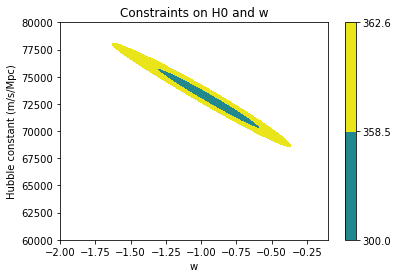

In [16]:
# Creating chi2 contours

Bchi = np.array(Bchi2).reshape(100,100)
W, h0 = np.meshgrid(w, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(W, h0, Bchi, levels=[300,358.51,362.60]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and w')
ax.set_xlabel('w')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

## C Bin

In [17]:
# Pantheon Data 

# Defining constants
K = int(input('Number of w data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)
w = np.linspace(-2,-0.1,K)
om = 0.298


crs = []
for i in H0:
    for j in Crs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([350,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value


colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in w:
    for j in Crs:
        def F(x):
            return 1/m.sqrt(om*(1+x)**3+(1-om)*((1+x)**(3*(1-i/(1+x))))*m.exp(6*i*(1-1/(1+x))))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([350,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in Cmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Cchidict = {}
# Obtaining chi2 value at each omg_m
Cchi2 = []
for i in range(K*H):
    cdrv = np.dot(invCC,drv[i])
    Cchi2i = np.dot(drv[i].T,cdrv)
    Cchi2.append(Cchi2i)
    Cchidict[Cchi2[i]] = i

print('The minimum chi2 value is ',min(Cchidict.keys()))
print('The ith value for minimum chi2 is ',Cchidict[min(Cchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Cchidict[min(Cchidict.keys())]/K)])
print('The w value for minimum chi2 is ',w[Cchidict[min(Cchidict.keys())]-int(Cchidict[min(Cchidict.keys())]/K)*K])

Number of w data points:100
Number of H_0 data points:100
The minimum chi2 value is  317.79642926239364
The ith value for minimum chi2 is  6849
The H0 value for minimum chi2 is  73737.37373737374
The w value for minimum chi2 is  -1.0595959595959596


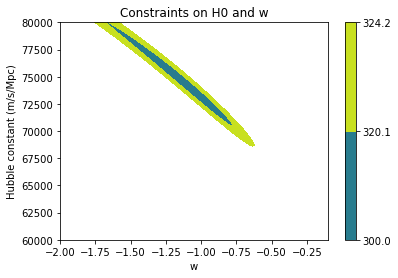

In [18]:
# Creating chi2 contours

Cchi = np.array(Cchi2).reshape(100,100)
W, h0 = np.meshgrid(w, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(W, h0, Cchi, levels=[300,320.11,324.2]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and w')
ax.set_xlabel('w')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

## Redshift Binning (4 Bins)

In [19]:
Ars = []
Amb = []
Ai = []
Brs = []
Bmb = []
Bi = []
Crs = []
Cmb = []
Ci = []
Drs = []
Dmb = []
Di = []

for i in range(len(rs)):
    if (rs[i] <= 0.132):
        Ars.append(rs[i])
        Amb.append(mb[i])
        Ai.append(i)
    elif (rs[i] > 0.132 and rs[i] <= 0.2485):
        Brs.append(rs[i])
        Bmb.append(mb[i])
        Bi.append(i)
    elif (rs[i] > 0.2485 and rs[i] <= 0.4235):
        Crs.append(rs[i])
        Cmb.append(mb[i])
        Ci.append(i)
    else:
        Drs.append(rs[i])
        Dmb.append(mb[i])
        Di.append(i)
        
np.array(Di).size

262

In [20]:
# Covariance for A-Bin
Acov = []
for i in range(len(Ai)):
    for j in range(len(Ai)):
        Acov.append(C[Ai[i]][Ai[j]])
AC = np.array(Acov).reshape([262,262],order='F')
invA = np.linalg.inv(AC)

# Covariance for B-Bin
Bcov = []
for i in range(len(Bi)):
    for j in range(len(Bi)):
        Bcov.append(C[Bi[i]][Bi[j]])
BC = np.array(Bcov).reshape([262,262],order='F')
invB = np.linalg.inv(BC)

# Covariance for C-Bin
Ccov = []
for i in range(len(Ci)):
    for j in range(len(Ci)):
        Ccov.append(C[Ci[i]][Ci[j]])
CC = np.array(Ccov).reshape([262,262],order='F')
invCC = np.linalg.inv(CC)

# Covariance for D-Bin
Dcov = []
for i in range(len(Di)):
    for j in range(len(Di)):
        Dcov.append(C[Di[i]][Di[j]])
DC = np.array(Dcov).reshape([262,262],order='F')
invD = np.linalg.inv(DC)

## A Bin

In [21]:
# Pantheon Data 

# Defining constants
K = int(input('Number of w data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)
w = np.linspace(-2,-0.1,K)
om = 0.298


crs = []
for i in H0:
    for j in Ars:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([262,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value


colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in w:
    for j in Ars:
        def F(x):
            return 1/m.sqrt(om*(1+x)**3+(1-om)*((1+x)**(3*(1-i/(1+x))))*m.exp(6*i*(1-1/(1+x))))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([262,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in Amb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Achidict = {}
# Obtaining chi2 value at each omg_m
Achi2 = []
for i in range(K*H):
    cdrv = np.dot(invA,drv[i])
    Achi2i = np.dot(drv[i].T,cdrv)
    Achi2.append(Achi2i)
    Achidict[Achi2[i]] = i

print('The minimum chi2 value is ',min(Achidict.keys()))
print('The ith value for minimum chi2 is ',Achidict[min(Achidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Achidict[min(Achidict.keys())]/K)])
print('The w value for minimum chi2 is ',w[Achidict[min(Achidict.keys())]-int(Achidict[min(Achidict.keys())]/K)*K])

Number of w data points:100
Number of H_0 data points:100
The minimum chi2 value is  248.53935991219305
The ith value for minimum chi2 is  7231
The H0 value for minimum chi2 is  74545.45454545454
The w value for minimum chi2 is  -1.405050505050505


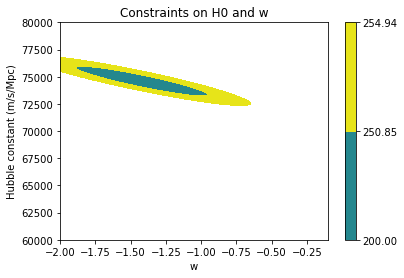

In [22]:
# Creating chi2 contours

Achi = np.array(Achi2).reshape(100,100)
W, h0 = np.meshgrid(w, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(W, h0, Achi, levels=[200,250.85,254.94]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and w')
ax.set_xlabel('w')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

## B Bin

In [23]:
# Pantheon Data 

# Defining constants
K = int(input('Number of w data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)
w = np.linspace(-2,-0.1,K)
om = 0.298


crs = []
for i in H0:
    for j in Brs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([262,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value


colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in w:
    for j in Brs:
        def F(x):
            return 1/m.sqrt(om*(1+x)**3+(1-om)*((1+x)**(3*(1-i/(1+x))))*m.exp(6*i*(1-1/(1+x))))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([262,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in Bmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Bchidict = {}
# Obtaining chi2 value at each omg_m
Bchi2 = []
for i in range(K*H):
    cdrv = np.dot(invB,drv[i])
    Bchi2i = np.dot(drv[i].T,cdrv)
    Bchi2.append(Bchi2i)
    Bchidict[Bchi2[i]] = i

print('The minimum chi2 value is ',min(Bchidict.keys()))
print('The ith value for minimum chi2 is ',Bchidict[min(Bchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Bchidict[min(Bchidict.keys())]/K)])
print('The w value for minimum chi2 is ',w[Bchidict[min(Bchidict.keys())]-int(Bchidict[min(Bchidict.keys())]/K)*K])

Number of w data points:100
Number of H_0 data points:100
The minimum chi2 value is  287.9047431891544
The ith value for minimum chi2 is  5276
The H0 value for minimum chi2 is  70505.0505050505
The w value for minimum chi2 is  -0.5414141414141416


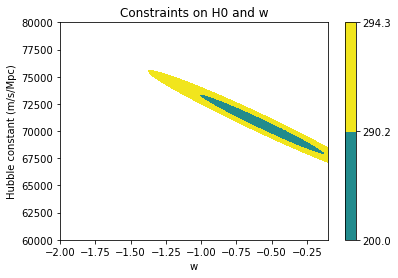

In [24]:
# Creating chi2 contours

Bchi = np.array(Bchi2).reshape(100,100)
W, h0 = np.meshgrid(w, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(W, h0, Bchi, levels=[200,290.21,294.3]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and w')
ax.set_xlabel('w')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

## C Bin

In [25]:
# Pantheon Data 

# Defining constants
K = int(input('Number of w data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)
w = np.linspace(-2,-0.1,K)
om = 0.298


crs = []
for i in H0:
    for j in Crs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([262,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value


colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in w:
    for j in Crs:
        def F(x):
            return 1/m.sqrt(om*(1+x)**3+(1-om)*((1+x)**(3*(1-i/(1+x))))*m.exp(6*i*(1-1/(1+x))))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([262,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in Cmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Cchidict = {}
# Obtaining chi2 value at each omg_m
Cchi2 = []
for i in range(K*H):
    cdrv = np.dot(invCC,drv[i])
    Cchi2i = np.dot(drv[i].T,cdrv)
    Cchi2.append(Cchi2i)
    Cchidict[Cchi2[i]] = i

print('The minimum chi2 value is ',min(Cchidict.keys()))
print('The ith value for minimum chi2 is ',Cchidict[min(Cchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Cchidict[min(Cchidict.keys())]/K)])
print('The w value for minimum chi2 is ',w[Cchidict[min(Cchidict.keys())]-int(Cchidict[min(Cchidict.keys())]/K)*K])

Number of w data points:100
Number of H_0 data points:100
The minimum chi2 value is  252.1452340768499
The ith value for minimum chi2 is  8332
The H0 value for minimum chi2 is  76767.67676767676
The w value for minimum chi2 is  -1.385858585858586


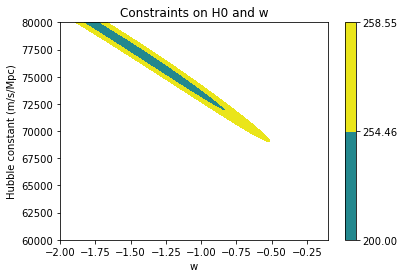

In [27]:
# Creating chi2 contours

Cchi = np.array(Cchi2).reshape(100,100)
W, h0 = np.meshgrid(w, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(W, h0, Cchi, levels=[200,254.46,258.55]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and w')
ax.set_xlabel('w')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()

## D Bin

In [28]:
# Pantheon Data 

# Defining constants
K = int(input('Number of w data points:'))
H = int(input('Number of H_0 data points:'))
c = 2.998*10**8 #Speed of light (m/s)
H0 = np.linspace(60000,80000,H) #Chosen Hubble constant value (m/s/Mpc)
w = np.linspace(-2,-0.1,K)
om = 0.298


crs = []
for i in H0:
    for j in Drs:
        crsi = c*(1+j)/i 
        crs.append(crsi)
argcrs = np.array(crs).reshape([262,H],order='F')
procrs = argcrs.T #Each row correspond to all 1048 redshift data per H0 value


colresult = [] #List to collect all the values in the loop
argresult = [] #list to arrange the result in 1048*10
for i in w:
    for j in Drs:
        def F(x):
            return 1/m.sqrt(om*(1+x)**3+(1-om)*((1+x)**(3*(1-i/(1+x))))*m.exp(6*i*(1-1/(1+x))))
        result, error = quad(F, 0, j) #Generate 1 integral result for each z-value 
        colresult.append(result) #1048*10 integral values for each redshift z value
argresult = np.array(colresult).reshape([262,K],order='F')
# Rearrange such that each row yields 1048 integral-values of each omg_m value (i.e. row[0] is integral value for omg_m = 0.1)
proint = argresult.T 

# Defining distance luminosity 
dL = []
for i in range(K):
    for j in range(H):    
        dLi = np.multiply(procrs[i],proint[j])
        dL.append(dLi)

# Defining theoretical distance modulus for each omg_m
uth = []
for i in range(K*H):
    uthi = [5*m.log10(j)+25 for j in dL[i]]
    uth.append(uthi)
Uth = np.array(uth)

# Defining observational distance modulus
M = -19.244 #absolute magnitude of Type 1a Supernovae
Uobs = np.array([i-M for i in Dmb])

# Distance residual vector for each omg_m
drv = []
for i in range(K*H):
    drvi = np.subtract(Uobs,Uth[i])
    drv.append(drvi)
    
Dchidict = {}
# Obtaining chi2 value at each omg_m
Dchi2 = []
for i in range(K*H):
    cdrv = np.dot(invD,drv[i])
    Dchi2i = np.dot(drv[i].T,cdrv)
    Dchi2.append(Dchi2i)
    Dchidict[Dchi2[i]] = i

print('The minimum chi2 value is ',min(Dchidict.keys()))
print('The ith value for minimum chi2 is ',Dchidict[min(Dchidict.keys())])
print('The H0 value for minimum chi2 is ',H0[int(Dchidict[min(Dchidict.keys())]/K)])
print('The w value for minimum chi2 is ',w[Dchidict[min(Dchidict.keys())]-int(Dchidict[min(Dchidict.keys())]/K)*K])

Number of w data points:100
Number of H_0 data points:100
The minimum chi2 value is  232.22417259313397
The ith value for minimum chi2 is  6155
The H0 value for minimum chi2 is  72323.23232323233
The w value for minimum chi2 is  -0.9444444444444444


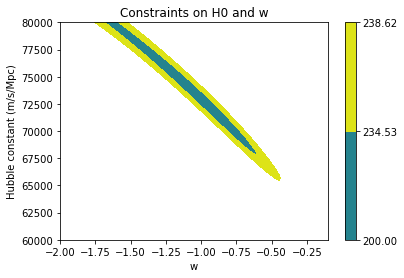

In [29]:
# Creating chi2 contours

Dchi = np.array(Dchi2).reshape(100,100)
W, h0 = np.meshgrid(w, H0)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(W, h0, Dchi, levels=[200,234.53,238.62]) #+2.31; 6.4
fig.colorbar(cp)
ax.set_title('Constraints on H0 and w')
ax.set_xlabel('w')
ax.set_ylabel('Hubble constant (m/s/Mpc)')

#plt.xlim([0,1])
#plt.ylim([65000,80000])
plt.show()